# Ejercicio 2. Modelos de Clasificación

In [ ]:
# utilidades_generales
import numpy as np
import pandas as pd
import time, joblib, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb


X = df_train_full.drop('isFraud', axis=1)
y = df_train_full['isFraud']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
pos, neg = y_train.sum(), len(y_train) - y_train.sum()
escala = neg / pos


In [ ]:
resultados = pd.DataFrame(columns=['modelo','precision','recall','f1','auc'])

# **1. KNN**

## **1.1 Entrenamiento**

In [ ]:
inicio = time.time()
pipe_knn = ImbPipeline([('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)), ('modelo', KNeighborsClassifier())])

# Espacio de hiperparámetros reducido
param_grid = {
    'modelo__n_neighbors': [3, 5, 7, 9, 11],
    'modelo__weights': ['uniform', 'distance']
}

grid_knn = GridSearchCV(pipe_knn, param_grid, scoring='roc_auc',
                       n_jobs=-1, cv=cv, verbose=1)

print('Entrenando KNN')
grid_knn.fit(X_train, y_train)

print('\nMejores parámetros encontrados:')
print(grid_knn.best_params_)
print('Mejor AUC validación:', grid_knn.best_score_)
print('Tiempo:', time.time() - inicio)

joblib.dump(grid_knn.best_estimator_, 'drive/MyDrive/punto_2_knn.pkl')
# joblib.dump(grid_knn.best_estimator_, './knn.pkl')

Entrenando KNN
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Mejores parámetros encontrados:
{'modelo__n_neighbors': 11, 'modelo__weights': 'distance'}
Mejor AUC validación: 0.8598671802341672
Tiempo: 7882.271107435226


['drive/MyDrive/punto_2_knn.pkl']

## **1.2 Métricas**

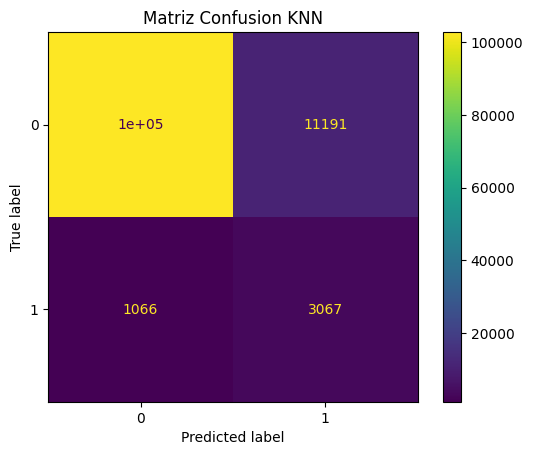

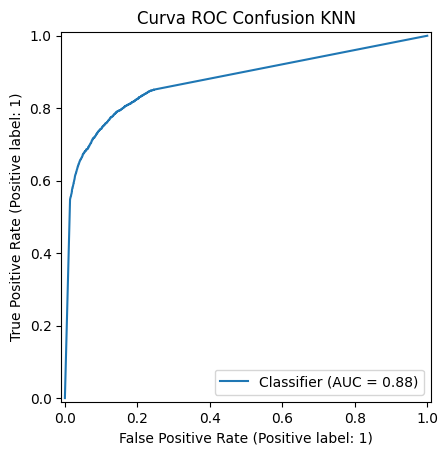

              precision    recall  f1-score   support

           0       0.99      0.90      0.94    113975
           1       0.22      0.74      0.33      4133

    accuracy                           0.90    118108
   macro avg       0.60      0.82      0.64    118108
weighted avg       0.96      0.90      0.92    118108



,modelo,precision,recall,f1,auc
0,KNN,0.215107,0.742076,0.333533,0.877271


In [ ]:
modelo_knn = joblib.load('drive/MyDrive/punto_2_knn.pkl')
pro_knn = modelo_knn.predict_proba(X_val)[:, 1]
pr_knn = (pro_knn >= 0.5).astype(int)
cm_knn = confusion_matrix(y_val, pr_knn)
ConfusionMatrixDisplay(cm_knn).plot()
plt.title("Matriz Confusion KNN")
plt.show()

RocCurveDisplay.from_predictions(y_val, pro_knn)
plt.title("Curva ROC Confusion KNN")
plt.show()
res = ['KNN', precision_score(y_val, pr_knn), recall_score(y_val, pr_knn), f1_score(y_val, pr_knn), roc_auc_score(y_val, pro_knn)]
resultados.loc[len(resultados)] = res;

print(classification_report(y_val, pr_knn))

resultados

<div style="border-left: 6px solid #2ecc71; border-radius: 6px; overflow: hidden;"> <div style="background-color: #d4f8e8; padding: 8px 12px;"> <strong>💡 Análisis:</strong> </div> <div style="background-color: #f5fdf9; padding: 12px;">  <ul> <li>La **clase 0** tiene un rendimiento muy alto en todas las métricas (precisión, recall, f1-score), con valores cercanos a 1.0. Esto indica que el modelo es muy bueno prediciendo la clase 0.</il> <li>La **clase 1** tiene un recall relativamente alto (0.74), lo que significa que el modelo identifica una buena proporción de los casos reales de la clase 1. Sin embargo, la precisión es baja (0.22), lo que sugiere que cuando el modelo predice la clase 1, a menudo se equivoca. El f1-score para la clase 1 es significativamente más bajo que para la clase 0, lo que refleja el compromiso entre precisión y recall.</li> <li>La **precisión general** es alta (0.90), lo cual es de esperar dado el alto rendimiento en la clase 0 y el gran soporte de esta clase (113975 instancias) en comparación con la clase 1 (4133 instancias).</li> <li>El *macro avg* (promedio no ponderado) muestra un rendimiento más equilibrado en cuanto a recall (0.82), pero la precisión y el f1-score son más bajos (0.60 y 0.64 respectivamente), lo que destaca el menor rendimiento en la clase minoritaria (clase 1).</li> <li>El **weighted avg** (promedio ponderado) se parece más a las métricas de la clase 0 debido al desequilibrio en el soporte de las clases.</li> </ul> <br>

   <strong> Conclusiones: </strong>
  </div>
  <div style="background-color: #f5fdf9; padding: 12px;"> <ul> <li>El modelo funciona muy bien para la clase mayoritaria (clase 0), pero tiene dificultades con la precisión en la predicción de la clase minoritaria (clase 1), a pesar de tener un recall decente para esta última. Esto es una observación común en conjuntos de datos desequilibrados. </li> </ul> <br>

# **2. Regresión Logística**

## **2.1 Entrenamiento**

In [ ]:

inicio = time.time()
pipe_log = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('modelo', LogisticRegression(
        max_iter=100,
        n_jobs=-1,
        class_weight='balanced',
        solver='saga',
        random_state=42
    ))
])

# Espacio de búsqueda reducido y discreto
param_grid = {
    'modelo__C': [0.01, 0.1, 1, 10],
    'modelo__penalty': ['l1', 'l2']
}

grid_log = GridSearchCV(
    pipe_log,
    param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=1
)

print('Entrenando LogisticRegression')
grid_log.fit(X_train, y_train)

print('\nMejores parámetros encontrados:')
print(grid_log.best_params_)
print('Mejor AUC validación:', grid_log.best_score_)
print('Tiempo:', time.time() - inicio)

joblib.dump(grid_log.best_estimator_, 'drive/MyDrive/punto_2_logreg.pkl')

Entrenando LogisticRegression
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Mejores parámetros encontrados:
{'modelo__C': 1, 'modelo__penalty': 'l2'}
Mejor AUC validación: 0.8134225032662549
Tiempo: 649.0233550071716


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


['drive/MyDrive/punto_2_logreg.pkl']

## **2.2 Métricas**

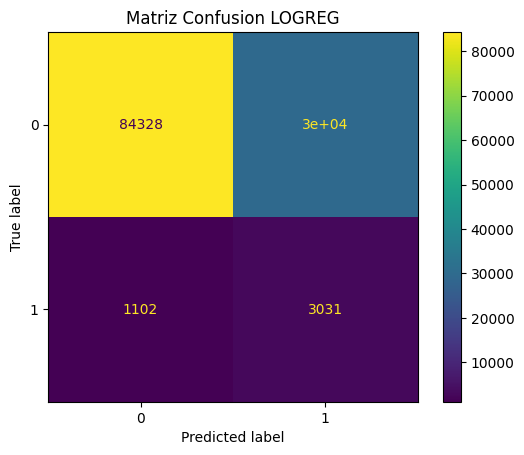

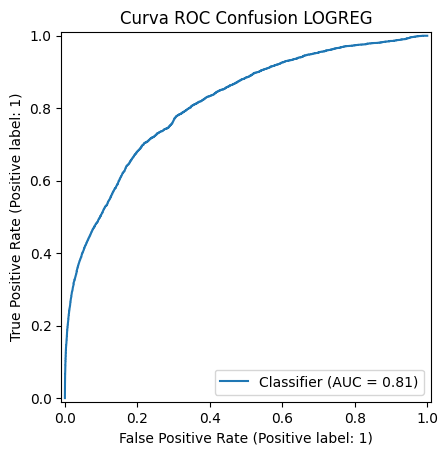

              precision    recall  f1-score   support

           0       0.99      0.74      0.85    113975
           1       0.09      0.73      0.16      4133

    accuracy                           0.74    118108
   macro avg       0.54      0.74      0.51    118108
weighted avg       0.96      0.74      0.82    118108



,modelo,precision,recall,f1,auc
0,KNN,0.215107,0.742076,0.333533,0.877271
1,Logistic Regression,0.092754,0.733366,0.164679,0.814901


In [ ]:
modelo_log = joblib.load('drive/MyDrive/punto_2_logreg.pkl')
pro_log = modelo_log.predict_proba(X_val)[:, 1]
pr_log = (pro_log >= 0.5).astype(int)
cm_log = confusion_matrix(y_val, pr_log)
ConfusionMatrixDisplay(cm_log).plot()
plt.title("Matriz Confusion LOGREG")
plt.show()
RocCurveDisplay.from_predictions(y_val, pro_log)

plt.title("Curva ROC Confusion LOGREG")
plt.show()
res = ['Logistic Regression', precision_score(y_val, pr_log), recall_score(y_val, pr_log), f1_score(y_val, pr_log), roc_auc_score(y_val, pro_log)]
resultados.loc[len(resultados)] = res;
print(classification_report(y_val, pr_log))

resultados


<div style="border-left: 6px solid #2ecc71; border-radius: 6px; overflow: hidden;"> <div style="background-color: #d4f8e8; padding: 8px 12px;"> <strong>💡 Análisis:</strong> </div> <div style="background-color: #f5fdf9; padding: 12px;">  <ul> <li>La **clase 0** muestra un recall considerablemente más bajo (0.74) en comparación con el modelo anterior, aunque su precisión sigue siendo alta (0.99). Esto indica que el modelo no está identificando correctamente una parte significativa de los casos reales de la clase 0.</li> <li>La **clase 1** mantiene un recall alto (0.73), similar al modelo anterior. Sin embargo, su precisión sigue siendo muy baja (0.09). El f1-score para la clase 1 es extremadamente bajo (0.16), reflejando la baja precisión.</li> <li>La **precisión general** ha disminuido a 0.74, lo cual es una consecuencia directa de la menor capacidad del modelo para recordar la clase 0.</li> <li>El **macro avg** refleja la disparidad en el rendimiento entre las clases, con una precisión baja (0.54) y un f1-score bajo (0.51), a pesar de un recall promedio más alto (0.74).</li> <li>El **weighted avg** muestra un rendimiento general más cercano a la precisión de la clase 0 debido a su mayor soporte, pero se ve afectado por la disminución en el recall de esta clase.</li> </ul> <br>

   <strong> Conclusiones: </strong>
  </div>
  <div style="background-color: #f5fdf9; padding: 12px;"> <ul> <li>En comparación con los resultados anteriores, este modelo ha sacrificado significativamente el recall de la clase mayoritaria (clase 0) para mantener un recall alto en la clase minoritaria (clase 1). Sin embargo, la precisión en la clase 1 sigue siendo un problema importante. Esto permite inferir que el modelo tiene dificultades para diferenciar correctamente entre las dos clases, especialmente al predecir la clase 1. </li> </ul> <br>

# **3. Clasificación Bayesiana**

## **3.1 Entrenamiento**

In [ ]:
inicio = time.time()
pipe_nb = ImbPipeline([('smote', SMOTE(random_state=42)), ('modelo', GaussianNB())])

# Espacio de búsqueda reducido con valores específicos
param_grid = {
    'modelo__var_smoothing': [1e-11, 1e-09, 1e-07]
}

grid_nb = GridSearchCV(
    pipe_nb,
    param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=1
)

print('Entrenando GaussianNB')
grid_nb.fit(X_train, y_train)

print('\nMejores parámetros encontrados:')
print(grid_nb.best_params_)
print('Mejor AUC validación:', grid_nb.best_score_)
print('Tiempo:', time.time() - inicio)

joblib.dump(grid_nb.best_estimator_, 'drive/MyDrive/punto_2_bayes.pkl')

Entrenando GaussianNB
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Mejores parámetros encontrados:
{'modelo__var_smoothing': 1e-11}
Mejor AUC validación: 0.6818327199112865
Tiempo: 28.220012426376343


['drive/MyDrive/punto_2_bayes.pkl']

## **3.2 Métricas**

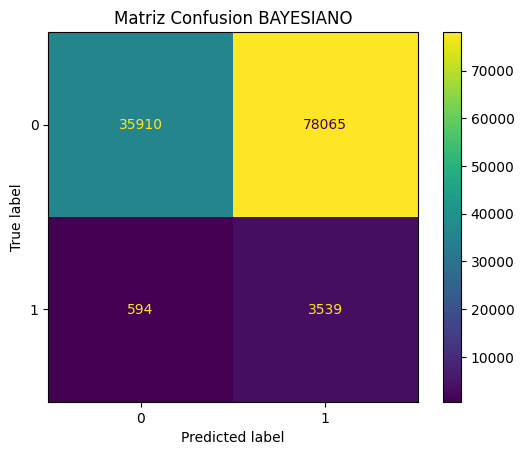

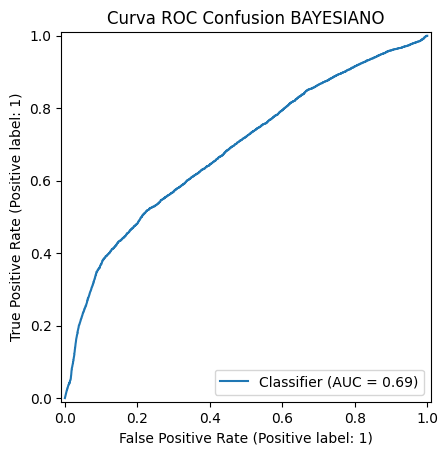

              precision    recall  f1-score   support

           0       0.98      0.32      0.48    113975
           1       0.04      0.86      0.08      4133

    accuracy                           0.33    118108
   macro avg       0.51      0.59      0.28    118108
weighted avg       0.95      0.33      0.46    118108



,modelo,precision,recall,f1,auc
0,KNN,0.215107,0.742076,0.333533,0.877271
1,Logistic Regression,0.092754,0.733366,0.164679,0.814901
2,Bayesian Classification,0.043368,0.856279,0.082555,0.686120


In [ ]:
modelo_nb = joblib.load('drive/MyDrive/punto_2_bayes.pkl')
pro_nb = modelo_nb.predict_proba(X_val)[:, 1]
pr_nb = (pro_nb >= 0.5).astype(int)
cm_nb = confusion_matrix(y_val, pr_nb)
ConfusionMatrixDisplay(cm_nb).plot()
plt.title("Matriz Confusion BAYESIANO")
plt.show()

RocCurveDisplay.from_predictions(y_val, pro_nb)
plt.title("Curva ROC Confusion BAYESIANO")
plt.show()
res = ['Bayesian Classification', precision_score(y_val, pr_nb), recall_score(y_val, pr_nb), f1_score(y_val, pr_nb), roc_auc_score(y_val, pro_nb)]
resultados.loc[len(resultados)] = res;
print(classification_report(y_val, pr_nb))

resultados

<div style="border-left: 6px solid #2ecc71; border-radius: 6px; overflow: hidden;"> <div style="background-color: #d4f8e8; padding: 8px 12px;"> <strong>💡 Análisis:</strong> </div> <div style="background-color: #f5fdf9; padding: 12px;">  <ul> <li>La **clase 0** mantiene una precisión muy alta (0.98), pero su recall ha caído drásticamente a 0.32. Esto significa que el modelo es muy preciso cuando predice la clase 0, pero no logra identificar la mayoría de los casos reales de esta clase. El f1-score para la clase 0 es moderado (0.48) debido al bajo recall.</il> <li>La **clase 1** tiene un recall muy alto (0.86), lo que indica que el modelo es muy bueno identificando los casos reales de la clase minoritaria. Sin embargo, su precisión es extremadamente baja (0.04), lo que significa que casi todas las predicciones positivas para la clase 1 son incorrectas. El f1-score para la clase 1 es muy bajo (0.08) debido a la bajísima precisión.</li> <li>La **precisión general** es muy baja (0.33), lo cual es un reflejo del bajo recall en la clase mayoritaria.</li> <li>El **macro avg** muestra valores bajos en todas las métricas (precisión 0.51, recall 0.59, f1-score 0.28), lo que indica un rendimiento general bajo cuando se promedian sin considerar el tamaño de las clases.</li> <li>El **weighted avg** es bajo (0.33 para recall y 0.46 para f1-score), motivado por el bajo recall de la clase mayoritaria.</li> </ul> <br>

   <strong> Conclusiones: </strong>
  </div>
  <div style="background-color: #f5fdf9; padding: 12px;"> <ul> <li>Este modelo ha priorizado de manera significativa el recall de la clase minoritaria (clase 1) a costa del recall de la clase mayoritaria (clase 0). Esto conlleva a una precisión muy baja en la clase 1 y una precisión general muy baja.</li> </ul> <br>

# **4. Árbol de Decisión**

## **4.1 Entrenamiento**

In [ ]:
from sklearn.model_selection import GridSearchCV

# arbol_entrenamiento
inicio = time.time()
pipe_dt = ImbPipeline([('smote', SMOTE(random_state=42)), ('modelo', DecisionTreeClassifier(class_weight='balanced', random_state=42))])

# Espacio de búsqueda optimizado
param_grid = {
    'modelo__max_depth': [5, 10, 15, 20],
    'modelo__min_samples_split': [5, 10, 15],
    'modelo__criterion': ['gini', 'entropy']
}

grid_dt = GridSearchCV(
    pipe_dt,
    param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=1
)

print('Entrenando DecisionTree')
grid_dt.fit(X_train, y_train)

print('\nMejores parámetros encontrados:')
print(grid_dt.best_params_)
print('Mejor AUC validación:', grid_dt.best_score_)
print('Tiempo:', time.time() - inicio)

joblib.dump(grid_dt.best_estimator_, 'drive/MyDrive/punto_2_arbol.pkl')

Entrenando DecisionTree
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Mejores parámetros encontrados:
{'modelo__criterion': 'entropy', 'modelo__max_depth': 10, 'modelo__min_samples_split': 10}
Mejor AUC validación: 0.8317573436143583
Tiempo: 498.2491271495819


['drive/MyDrive/punto_2_arbol.pkl']

## **4.2 Métricas**

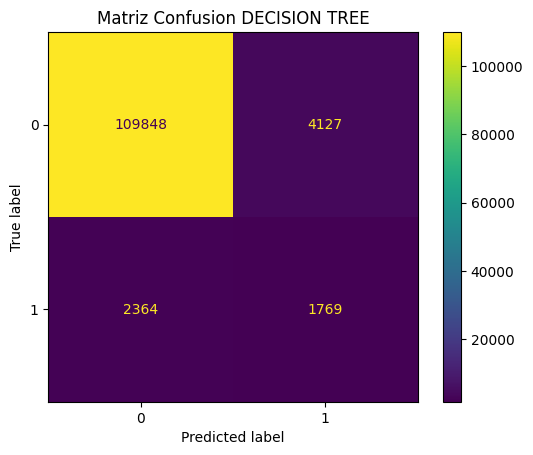

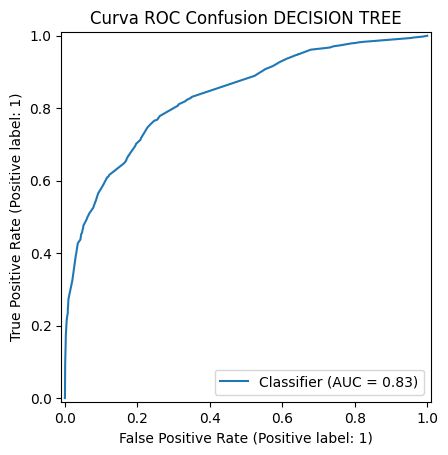

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    113975
           1       0.30      0.43      0.35      4133

    accuracy                           0.95    118108
   macro avg       0.64      0.70      0.66    118108
weighted avg       0.96      0.95      0.95    118108



,modelo,precision,recall,f1,auc
0,KNN,0.215107,0.742076,0.333533,0.877271
1,Logistic Regression,0.092754,0.733366,0.164679,0.814901
2,Bayesian Classification,0.043368,0.856279,0.082555,0.686120
3,Decision Tree,0.300034,0.428018,0.352777,0.833576


In [ ]:
modelo_dt = joblib.load('drive/MyDrive/punto_2_arbol.pkl')
pro_dt = modelo_dt.predict_proba(X_val)[:, 1]
pr_dt = (pro_dt >= 0.5).astype(int)
cm_dt = confusion_matrix(y_val, pr_dt)
ConfusionMatrixDisplay(cm_dt).plot()

plt.title("Matriz Confusion DECISION TREE")
plt.show()

RocCurveDisplay.from_predictions(y_val, pro_dt)
plt.title("Curva ROC Confusion DECISION TREE")
plt.show()

res = ['Decision Tree', precision_score(y_val, pr_dt), recall_score(y_val, pr_dt), f1_score(y_val, pr_dt), roc_auc_score(y_val, pro_dt)]
resultados.loc[len(resultados)] = res
print(classification_report(y_val, pr_dt))

resultados


<div style="border-left: 6px solid #2ecc71; border-radius: 6px; overflow: hidden;"> <div style="background-color: #d4f8e8; padding: 8px 12px;"> <strong>💡 Análisis:</strong> </div> <div style="background-color: #f5fdf9; padding: 12px;"> <ul> <li>La **clase 0** muestra un rendimiento excelente con alta precisión (0.98) y recall (0.96), lo que resulta en un f1-score muy alto (0.97). Esto indica que el modelo es muy efectivo identificando correctamente la mayoría de los casos de la clase mayoritaria.</li> <li>La **clase 1** tiene un recall moderado (0.43), lo que significa que el modelo identifica menos de la mitad de los casos reales de la clase minoritaria. La precisión es baja (0.30), lo que indica que hay un número significativo de falsos positivos al predecir la clase 1. El f1-score para la clase 1 es bajo (0.35), reflejando el compromiso entre recall y precisión en esta clase.</li> <li>La **precisión general** es alta (0.95), lo cual es esperado dado el fuerte rendimiento en la clase mayoritaria.</li> <li>El **macro avg** (promedio no ponderado) muestra un equilibrio entre las métricas (precisión 0.64, recall 0.70, f1-score 0.66), lo que proporciona una visión más equitativa del rendimiento en ambas clases, aunque todavía influenciado por el menor rendimiento en la clase minoritaria.</li> <li>El **weighted avg** (promedio ponderado) es alto (0.95 para recall y f1-score, 0.96 para precisión), reflejando el dominio de la clase mayoritaria en el conjunto de datos.</li> </ul> <br>

   <strong> Conclusiones: </strong>
  </div>
  <div style="background-color: #f5fdf9; padding: 12px;"> <ul> <li>Este modelo parece haber encontrado un mejor equilibrio entre el rendimiento en la clase mayoritaria y minoritaria. Si bien el rendimiento en la clase 1 todavía no es tan alto como en la clase 0, ha mejorado con respecto a los escenarios donde el recall de la clase 0 era muy bajo. Este modelo ofrece un buen rendimiento general. </li> </ul> <br>

# **5. Bosques Aleatorios**

## **5.1 Entrenamiento**

In [ ]:
inicio = time.time()
pipe_rf = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('modelo', RandomForestClassifier(
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
))])

# Espacio de búsqueda reducido
param_grid = {
    'modelo__n_estimators': [100, 200],
    'modelo__max_depth': [10, 15, 20],
    'modelo__max_features': ['sqrt', 'log2']
}

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=1
)

print('Entrenando RandomForest')
grid_rf.fit(X_train, y_train)

print('\nMejores parámetros encontrados:')
print(grid_rf.best_params_)
print('Mejor AUC validación:', grid_rf.best_score_)
print('Tiempo:', time.time() - inicio)

joblib.dump(grid_rf.best_estimator_, 'drive/MyDrive/punto_2_rf.pkl')

Entrenando RandomForest
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Mejores parámetros encontrados:
{'modelo__max_depth': 20, 'modelo__max_features': 'sqrt', 'modelo__n_estimators': 200}
Mejor AUC validación: 0.9084535084467271
Tiempo: 2375.4289305210114


['drive/MyDrive/punto_2_rf.pkl']

## **5.2 Métricas**

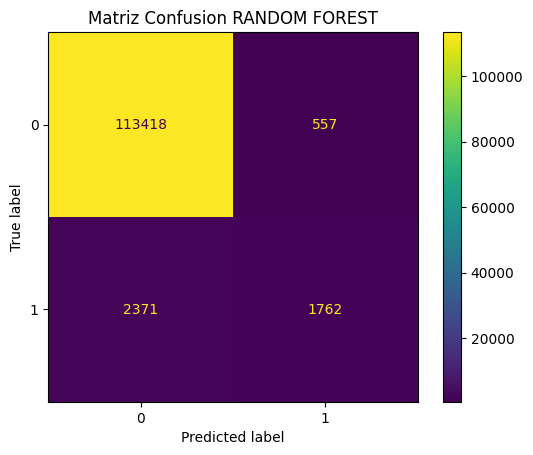

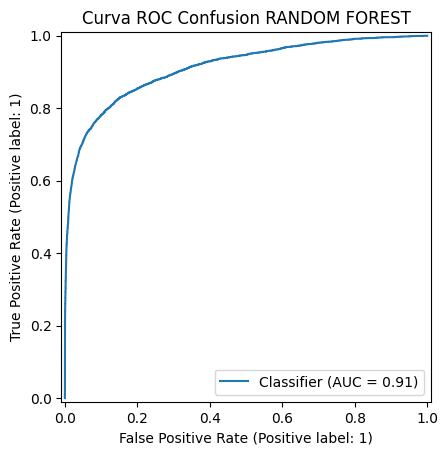

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.76      0.43      0.55      4133

    accuracy                           0.98    118108
   macro avg       0.87      0.71      0.77    118108
weighted avg       0.97      0.98      0.97    118108



,modelo,precision,recall,f1,auc
0,KNN,0.215107,0.742076,0.333533,0.877271
1,Logistic Regression,0.092754,0.733366,0.164679,0.814901
2,Bayesian Classification,0.043368,0.856279,0.082555,0.686120
3,Decision Tree,0.300034,0.428018,0.352777,0.833576
4,Random Forest,0.759810,0.426325,0.546187,0.912900


In [ ]:
modelo_rf = joblib.load('drive/MyDrive/punto_2_rf.pkl')
pro_rf = modelo_rf.predict_proba(X_val)[:, 1]
pr_rf = (pro_rf >= 0.5).astype(int)
cm_rf = confusion_matrix(y_val, pr_rf)
ConfusionMatrixDisplay(cm_rf).plot()
plt.title("Matriz Confusion RANDOM FOREST")
plt.show()
RocCurveDisplay.from_predictions(y_val, pro_rf)
plt.title("Curva ROC Confusion RANDOM FOREST")
plt.show()
res = ['Random Forest', precision_score(y_val, pr_rf), recall_score(y_val, pr_rf), f1_score(y_val, pr_rf), roc_auc_score(y_val, pro_rf)]
resultados.loc[len(resultados)] = res
print(classification_report(y_val, pr_rf))

resultados


<div style="border-left: 6px solid #2ecc71; border-radius: 6px; overflow: hidden;"> <div style="background-color: #d4f8e8; padding: 8px 12px;"> <strong>💡 Análisis:</strong> </div> <div style="background-color: #f5fdf9; padding: 12px;"> <ul> <li>La **clase 0** muestra un rendimiento con una precisión de 0.98 y un recall de 1.00, lo que resulta en un f1-score de 0.99. Esto indica que el modelo identifica correctamente a todas las instancias de la clase mayoritaria y casi todas sus predicciones positivas son correctas.</li> <li>La **clase 1** tiene una precisión relativamente alta (0.76) en comparación con los ejemplos anteriores, lo que significa que cuando el modelo predice la clase 1, hay una buena probabilidad de que sea correcto. Sin embargo, el recall es bajo (0.43), lo que indica que el modelo solo logra identificar menos de la mitad de los casos reales de la clase minoritaria. El f1-score para la clase 1 es moderado (0.55), reflejando el bajo recall a pesar de la precisión mejorada.</li> <li>La **precisión general** es muy alta (0.98), lo cual se debe principalmente al excelente rendimiento en la clase mayoritaria.</li> <li>El **macro avg** muestra un mejor equilibrio en las métricas en comparación con ejemplos anteriores, con valores más altos para precisión (0.87), recall (0.71) y f1-score (0.77), lo que indica un mejor rendimiento general sin ponderar por el tamaño de la clase.</li> <li>El **weighted avg** es muy alto (0.97-0.98), reflejando el dominio de la clase mayoritaria.</li> </ul> <br>

   <strong> Conclusiones: </strong>
  </div>
  <div style="background-color: #f5fdf9; padding: 12px;"> <ul> <li>Este modelo muestra un rendimiento muy fuerte en la clase mayoritaria y una mejora significativa en la precisión para la clase minoritaria en comparación con ejemplos anteriores. Aunque el recall para la clase minoritaria sigue siendo bajo, la alta precisión en esta clase sugiere que las predicciones positivas para la clase 1 son más confiables. </li> </ul> <br>

# **6. XGBoost**

## **6.1 Entrenamiento**

In [ ]:
inicio = time.time()
pipe_xgb = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
     ('modelo', xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_jobs=-1,
    scale_pos_weight=escala,
    random_state=42
))])

# Espacio de búsqueda simplificado
param_grid = {
    'modelo__max_depth': [3, 4, 5],          # 3 valores en lugar de rango
    'modelo__n_estimators': [100, 200],       # 2 valores clave
    'modelo__learning_rate': [0.1, 0.2]       # Valores comunes predefinidos
}

grid_xgb = GridSearchCV(
    pipe_xgb,
    param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=1
)

print('Entrenando XGBoost')
grid_xgb.fit(X_train, y_train)

print('\nMejores parámetros encontrados:')
print(grid_xgb.best_params_)
print('Mejor AUC validación:', grid_xgb.best_score_)
print('Tiempo:', time.time() - inicio)

joblib.dump(grid_xgb.best_estimator_, 'drive/MyDrive/punto_2_xgb.pkl')

Entrenando XGBoost
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Mejores parámetros encontrados:
{'modelo__learning_rate': 0.2, 'modelo__max_depth': 5, 'modelo__n_estimators': 200}
Mejor AUC validación: 0.912648639859673
Tiempo: 347.3052227497101


['drive/MyDrive/xgb.pkl']

## **6.2 Métricas**

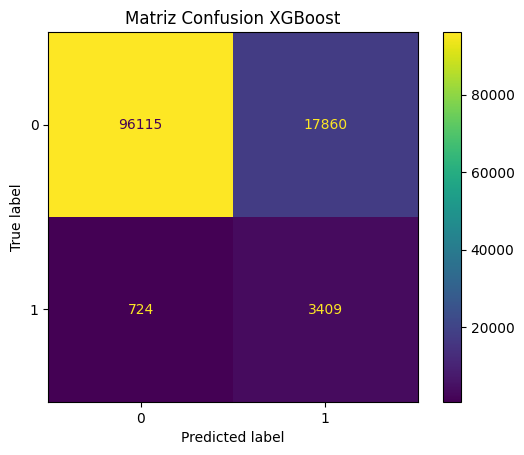

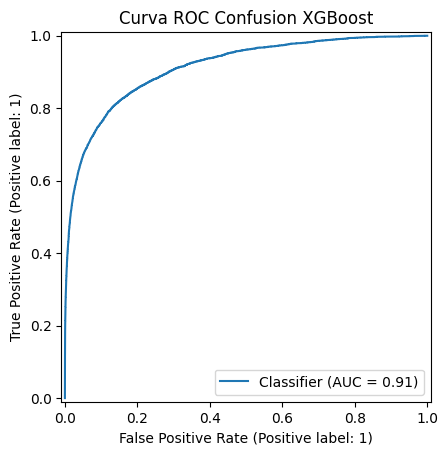

              precision    recall  f1-score   support

           0       0.99      0.84      0.91    113975
           1       0.16      0.82      0.27      4133

    accuracy                           0.84    118108
   macro avg       0.58      0.83      0.59    118108
weighted avg       0.96      0.84      0.89    118108



,modelo,precision,recall,f1,auc
0,KNN,0.215107,0.742076,0.333533,0.877271
1,Logistic Regression,0.092754,0.733366,0.164679,0.814901
2,Bayesian Classification,0.043368,0.856279,0.082555,0.686120
3,Decision Tree,0.300034,0.428018,0.352777,0.833576
4,Random Forest,0.759810,0.426325,0.546187,0.912900
5,XGBoost,0.160280,0.824825,0.268404,0.913099


In [ ]:
modelo_xgb = joblib.load('drive/MyDrive/punto_2_xgb.pkl')
pro_xgb = modelo_xgb.predict_proba(X_val)[:, 1]
pr_xgb = (pro_xgb >= 0.5).astype(int)
cm_xgb = confusion_matrix(y_val, pr_xgb)
ConfusionMatrixDisplay(cm_xgb).plot()
plt.title("Matriz Confusion XGBoost")
plt.show()

RocCurveDisplay.from_predictions(y_val, pro_xgb)
plt.title("Curva ROC Confusion XGBoost")
plt.show()
res = ['XGBoost', precision_score(y_val, pr_xgb), recall_score(y_val, pr_xgb), f1_score(y_val, pr_xgb), roc_auc_score(y_val, pro_xgb)]
resultados.loc[len(resultados)] = res
print(classification_report(y_val, pr_xgb))

resultados


<div style="border-left: 6px solid #2ecc71; border-radius: 6px; overflow: hidden;"> <div style="background-color: #d4f8e8; padding: 8px 12px;"> <strong>💡 Análisis:</strong> </div> <div style="background-color: #f5fdf9; padding: 12px;"> <br><br> <ul> <li>La **clase 0** tiene una precisión muy alta (0.99) y un recall bueno (0.84), lo que resulta en un f1-score alto (0.91). Esto indica que el modelo es muy preciso al predecir la clase mayoritaria y logra identificar la mayoría de sus casos reales.</li> <li>La **clase 1** tiene un recall muy alto (0.82), lo que significa que el modelo es muy bueno identificando los casos reales de la clase minoritaria. Sin embargo, la precisión es muy baja (0.16), lo que sugiere que la mayoría de las predicciones positivas para la clase 1 son incorrectas (altos falsos positivos). El f1-score para la clase 1 es bajo (0.27) debido a la baja precisión.</li> <li>La **precisión general** es buena (0.84), influenciada por el rendimiento sólido en la clase mayoritaria.</li> <li>El **macro avg** muestra un desequilibrio, con un recall alto (0.83) pero una precisión (0.58) y f1-score (0.59) más bajos, destacando el problema de precisión en la clase minoritaria.</li> <li>El **weighted avg** es alto (0.96 para precisión, 0.84 para recall, 0.89 para f1-score), reflejando el buen rendimiento general ponderado por el tamaño de las clases.</li> </ul> <br>

   <strong> Conclusiones: </strong>
  </div>
  <div style="background-color: #f5fdf9; padding: 12px;"> <ul> <li>Este modelo prioriza fuertemente el recall en la clase minoritaria (clase 1), logrando identificar una gran proporción de sus casos. Sin embargo, esto viene a costa de una precisión muy baja en la clase 1, lo que significa un alto número de falsos positivos. El rendimiento en la clase mayoritaria (clase 0) es bueno, aunque no perfecto en términos de recall. </li> </ul> <br>


# **7. MLP**

## **7.1 Entrenamiento**

In [ ]:
from sklearn.model_selection import GridSearchCV

inicio = time.time()
pipe_mlp = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('modelo', MLPClassifier(
        max_iter=100,
        early_stopping=True,
        random_state=42
    ))
])

# Espacio de búsqueda optimizado
param_grid = {
    'modelo__hidden_layer_sizes': [(64,), (128,), (256,)],
    'modelo__alpha': [0.0001, 0.001, 0.01]
}

grid_mlp = GridSearchCV(
    pipe_mlp,
    param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=1
)

print('Entrenando MLP')
grid_mlp.fit(X_train, y_train)

print('\nMejores parámetros encontrados:')
print(grid_mlp.best_params_)
print('Mejor AUC validación:', grid_mlp.best_score_)
print('Tiempo:', time.time() - inicio)

joblib.dump(grid_mlp.best_estimator_, 'drive/MyDrive/punto_2_mlp.pkl')

Entrenando MLP
Fitting 3 folds for each of 9 candidates, totalling 27 fits

Mejores parámetros encontrados:
{'modelo__alpha': 0.01, 'modelo__hidden_layer_sizes': (256,)}
Mejor AUC validación: 0.8674189478627773
Tiempo: 4345.680210590363


['drive/MyDrive/punto_2_mlp.pkl']

## **7.2 Métricas**

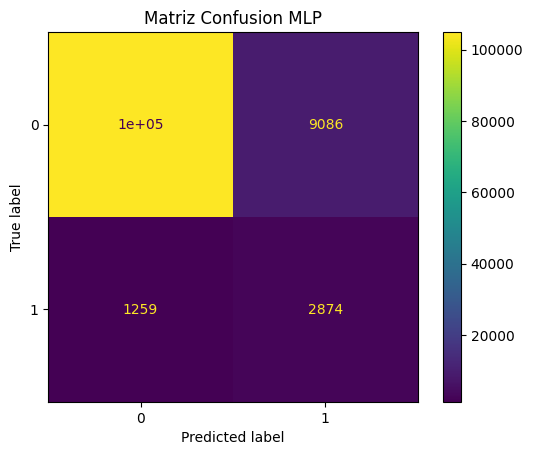

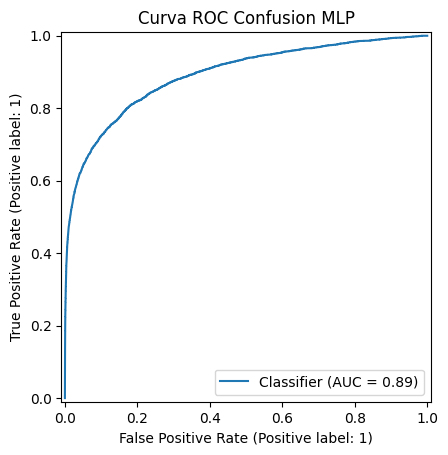

              precision    recall  f1-score   support

           0       0.99      0.92      0.95    113975
           1       0.24      0.70      0.36      4133

    accuracy                           0.91    118108
   macro avg       0.61      0.81      0.66    118108
weighted avg       0.96      0.91      0.93    118108



,modelo,precision,recall,f1,auc
0,KNN,0.215107,0.742076,0.333533,0.877271
1,Logistic Regression,0.092754,0.733366,0.164679,0.814901
2,Bayesian Classification,0.043368,0.856279,0.082555,0.686120
3,Decision Tree,0.300034,0.428018,0.352777,0.833576
4,Random Forest,0.759810,0.426325,0.546187,0.912900
5,XGBoost,0.160280,0.824825,0.268404,0.913099
6,MLP,0.240301,0.695379,0.357174,0.891795


In [ ]:
# mlp_metricas
modelo_mlp = joblib.load('drive/MyDrive/punto_2_mlp.pkl')
pro_mlp = modelo_mlp.predict_proba(X_val)[:, 1]
pr_mlp = (pro_mlp >= 0.5).astype(int)
cm_mlp = confusion_matrix(y_val, pr_mlp)
ConfusionMatrixDisplay(cm_mlp).plot()

plt.title("Matriz Confusion MLP")
plt.show()

RocCurveDisplay.from_predictions(y_val, pro_mlp)
plt.title("Curva ROC Confusion MLP")
plt.show()

res = ['MLP', precision_score(y_val, pr_mlp), recall_score(y_val, pr_mlp), f1_score(y_val, pr_mlp), roc_auc_score(y_val, pro_mlp)]

resultados.loc[len(resultados)] = res
print(classification_report(y_val, pr_mlp))

resultados


<div style="border-left: 6px solid #2ecc71; border-radius: 6px; overflow: hidden;"> <div style="background-color: #d4f8e8; padding: 8px 12px;"> <strong>💡 Análisis</strong> </div> <div style="background-color: #f5fdf9; padding: 12px;"> <ul> <li>La **clase 0** muestra una precisión muy alta (0.99) y un recall bueno (0.92), lo que resulta en un f1-score alto (0.95). Esto indica que el modelo es muy preciso al predecir la clase mayoritaria y logra identificar la gran mayoría de sus casos reales.</li> <li>La **clase 1** tiene un recall bueno (0.70), lo que significa que el modelo identifica una proporción significativa de los casos reales de la clase minoritaria. Sin embargo, la precisión es baja (0.24), lo que sugiere que hay un número considerable de falsos positivos al predecir la clase 1. El f1-score para la clase 1 es bajo (0.36) debido a la baja precisión.</li> <li>La **precisión general** es alta (0.91), influenciada por el buen rendimiento en la clase mayoritaria.</li> <li>El **macro avg** muestra un desequilibrio, con un recall alto (0.81) pero una precisión (0.61) y f1-score (0.66) más bajos, destacando el problema de precisión en la clase minoritaria.</li> <li>El **weighted avg** es alto (0.96 para precisión, 0.91 para recall, 0.93 para f1-score).</li> </ul> <br>

   <strong> Conclusiones: </strong>
  </div>
  <div style="background-color: #f5fdf9; padding: 12px;"> <ul> <li>Este modelo logra un buen equilibrio en el recall, identificando una proporción significativa de ambas clases. Sin embargo, la precisión en la clase minoritaria sigue siendo un desafío, lo que lleva a un número apreciable de falsos positivos para esa clase. El rendimiento general es sólido, pero la mejora en la precisión de la clase 1 sin sacrificar demasiado el recall sería el siguiente paso lógico. Este modelo sería adecuado en escenarios donde un buen recall en la clase minoritaria es importante, incluso si hay un número moderado de falsos positivos asociados. </li> </ul> <br>

### Analisis

|Modelo | AUC-ROC | Precision (fraude = 1) | Recall (fraude = 1) | F1-score (fraude = 1)|
|--------|------|------|------|------|
|Random Forest | 0.91 | 0.76 | 0.43 | 0.55|
|XGBoost | 0.91 | 0.16 | 0.82 | 0.27|
|MLP | 0.89 | 0.24 | 0.70 | 0.36|
|K-NN | 0.88 | 0.22 | 0.74 | 0.33|
|Decision Tree | 0.83 | 0.30 | 0.43 | 0.35|
|Logistic Regression | 0.81 | 0.09 | 0.73 | 0.16|
|Gaussian NB | 0.69 | 0.04 | 0.86 | 0.08|


  <strong> METRICAS:</strong>
  </div>
  <div style="background-color: #f5fdf9; padding: 12px;"> <ul> <li> **AUC-ROC:** Random Forest y XGBoost tienen el mejor rendimiento general en términos de la capacidad de distinguir entre clases positivas y negativas, con un AUC-ROC de 0.91. Gaussian NB tiene el peor AUC-ROC (0.69).<br><br> </li> <li>**Precision (fraude = 1):** Random Forest logra la mayor precisión para la clase minoritaria (fraude = 1) con 0.76. Esto significa que cuando Random Forest predice fraude, es más probable que sea correcto en comparación con los otros modelos. Gaussian NB tiene la menor precisión (0.04).<br><br></li> <li>**Recall (fraude = 1):** Gaussian NB y XGBoost tienen el mayor recall para la clase minoritaria (0.86 y 0.82 respectivamente). Esto indica que son los mejores identificando la mayoría de los casos reales de fraude. Random Forest y Decision Tree tienen el recall más bajo (0.43).<br><br> </li> <li>**F1-score (fraude = 1):** Random Forest tiene el mejor F1-score para la clase minoritaria (0.55), lo que representa el mejor equilibrio entre precisión y recall para detectar fraude. Gaussian NB tiene el F1-score más bajo (0.08).</li> </ul> <br>

 <strong> ANÁLISIS DE MODELOS: </strong>
  </div>
  <div style="background-color: #f5fdf9; padding: 12px;"> <ul> <li>
  **Random Forest** parece ser el modelo más equilibrado en general, ofreciendo el mejor F1-score y la mayor precisión para la detección de fraude. Aunque su recall no es el más alto, su alta precisión hace que sus predicciones de fraude sean más fiables.<br><br> </li> <li>**XGBoost y Gaussian NB** son los mejores para identificar la mayoría de los casos de fraude (alto recall), pero tienen una precisión muy baja, lo que resulta en un alto número de falsos positivos.<br><br> </li> <li>**MLP y K-NN** ofrecen un recall moderado para la clase de fraude, pero su precisión es baja, lo que también lleva a un número significativo de falsos positivos.<br><br> </li> <li>**Decision Tree** y **Logistic Regression** tienen un rendimiento más débil en general, con un AUC-ROC más bajo y métricas para la clase de fraude menos destacadas en comparación con Random Forest.</li> </ul> <br>

 <strong> RECOMENDACIONES: </strong>
  </div>
  <div style="background-color: #f5fdf9; padding: 12px;"> <ul> <li> La elección del mejor modelo dependerá de la prioridad del negocio. Si minimizar los falsos positivos es crucial, **Random Forest** es probablemente la mejor opción. Si maximizar la detección de fraude (incluso con muchos falsos positivos) es la prioridad, **XGBoost o Gaussian NB** podrían considerarse, aunque con precaución debido a su baja precisión.</li> </ul> <br>

|Pregunta de negocio | Métrica crítica | Modelos más fuertes|
|------|------|------|
|¿Queremos investigar sólo alertas muy confiables? | Precision alta (menos falsos positivos) | Random Forest (0 .76)|
|¿Queremos capturar el mayor número de fraudes posible, aceptando más falsos positivos? | Recall alto | XGBoost (0 .82),  Gaussian NB (0 .86 aunque con muy bajo precision)|
|¿Buscamos balancear ambas cosas y maximizar la ganancia global? | AUC-ROC + ajuste de umbral | Random Forest / XGBoost|

1. **Random Forest**

    - Lo más valioso: AUC máximo y precision líder ⇒ pocas alarmas falsas (557 FP).

    - Lo que falta: su recall 0.43 deja escapar el 57 % del fraude.

2. **XGBoost**

    - Ventajas: iguala el AUC de RF y llega a 0.82 de recall, segundo mejor precision dentro de los modelos que priorizan cobertura.

    - Desventaja: todavía 17 860 FP; el coste operativo debe compararse con el ahorro de fraude.

3. **MLP**

    - Buen compromiso (0.24 / 0.70 precision/recall) y AUC 0.89, pero 4 h 20 min de entrenamiento en CPU.

    - Útil si se dispone de GPU o si se quiere un modelo “soft” para stacking.

4. **K-NN**

    - Recall 0.74 parecido a MLP, pero precision 0.22 y coste de predicción muy alto en producción (búsqueda de vecinos).

    - Puede servir como capa adicional en un ensamble votante.

5. **Decision Tree**

    - Interpretabilidad clara (profundidad 10), AUC aceptable.

    - Produce reglas que ayudan a explicar los modelos más complejos (extraer paths importantes del bosque).

6. **Logistic Regression**

    - Base lineal sencilla y rápida; muy bajo precision.

7. **Gaussian Naive Bayes**

    - Casi todo el fraude detectado (0.86 recall) pero precision 0.04: un “detector de humo” para descartar casos limpios NO es viable.

    - Sin embargo, como pre-filtro inverso (marcar definitivamente transacciones válidas con probabilidad < 0.01) puede aliviar el volumen de datos para modelos pesados.